In [4]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config


from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/florian/GitRepos/activeCell-ACDC
data		   log	   pipeline_configs  requirements.txt  src
jupyter_notebooks  output  README.md	     shell_scripts     wandb


In [ ]:
def show_image_by_id(image_id, ds_json):
    image_json = tuple(filter(lambda x: x["image_id"] == image_id,  ds_json))[0]
    raw_im = cv2.imread(image_json["file_name"])
    show_image([raw_im])

In [6]:
register_datasets()
ds_json = DatasetCatalog.get(get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
))

registering acdc_small dataset
registering acdc_large dataset



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [7]:
running_on_server = False
print("running on server:", running_on_server)
cfg = get_config("acdc_large_al")

mc_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)
rd_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)


#al_trainer.run(dataset=ACDC_LARGE, query_strat=MC_DROPOUT)
#al_trainer.run(dataset=ACDC_LARGE, query_strat=RANDOM)
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

mc_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
)
rd_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
)
mc_trainer.al_dataset = ActiveLearingDataset(mc_trainer.cfg)
rd_trainer.al_dataset = ActiveLearingDataset(rd_trainer.cfg)

mc_trainer.query_strategy = MCDropoutSampler(mc_trainer.cfg)
rd_trainer.query_strategy = RandomSampler(rd_trainer.cfg)


running on server: False
registering acdc_small dataset
registering acdc_large dataset
[01/13 08:06:25 d2.data.datasets.coco]: Loading ./data/acdc_large/train/cell_acdc_coco_ds.json takes 4.55 seconds.
WARNING [01/13 08:06:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/13 08:06:26 d2.data.datasets.coco]: Loaded 5499 images in COCO format from ./data/acdc_large/train/cell_acdc_coco_ds.json
update_labeled_data
registering acdc_small dataset
registering acdc_large dataset
[01/13 08:06:31 d2.data.datasets.coco]: Loading ./data/acdc_large/train/cell_acdc_coco_ds.json takes 4.33 seconds.
WARNING [01/13 08:06:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/13 08:06:31 d2.data.datasets.coco]: Loaded 5499 images in COCO format from ./data/acdc_large/train/cell_acdc_coco_ds.json
update_labeled_data


['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_224'] ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_4_224']


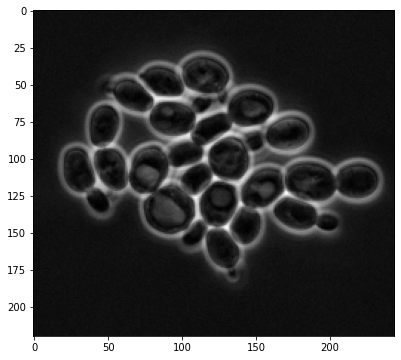

In [8]:
print(mc_trainer.al_dataset.labeled_ids,rd_trainer.al_dataset.labeled_ids)
show_image_by_id(mc_trainer.al_dataset.labeled_ids[0])


In [9]:
i = 0

In [10]:
mc_trainer.step(resume=(i > 0))
rd_trainer.step(resume=(i > 0))
i += 1
print(mc_trainer.al_dataset.labeled_ids,rd_trainer.al_dataset.labeled_ids)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/13 08:06:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomFlip(prob=0.5), RandomFlip(prob=0.5, horizontal=False, vertical=True), ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[01/13 08:06:37 d2.data.datasets.coco]: Loading ./data/acdc_large/train/cell_acdc_coco_ds.json takes 4.48 seconds.
WARNING [01/13 08:06:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/13 08:06:37 d2.data.datasets.coco]: Loaded 5499 images in COCO format from ./data/acdc_large/train/cell_acdc_coco_ds.json
[01/13 08:06:38 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[01/13 08:06:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 33           |
|            |              |
[01/13 08:06:38 d2.data.build]: Using training sampl

/home/florian/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/13 08:06:45 d2.utils.events]:  iter: 19  total_loss: 5.708  loss_cls: 0.7178  loss_box_reg: 0.7645  loss_mask: 0.6933  loss_rpn_cls: 3.381  loss_rpn_loc: 0.1913  lr: 1.1689e-05  max_mem: 2010M
[01/13 08:06:50 d2.utils.events]:  eta: 11 days, 15:09:14  iter: 39  total_loss: 3.015  loss_cls: 0.6539  loss_box_reg: 0.8449  loss_mask: 0.6665  loss_rpn_cls: 0.7008  loss_rpn_loc: 0.1573  lr: 2.3677e-05  max_mem: 2010M
[01/13 08:06:55 d2.utils.events]:  eta: 11 days, 22:45:17  iter: 59  total_loss: 2.223  loss_cls: 0.5304  loss_box_reg: 0.7826  loss_mask: 0.609  loss_rpn_cls: 0.1733  loss_rpn_loc: 0.1234  lr: 3.5665e-05  max_mem: 2010M
[01/13 08:07:00 d2.utils.events]:  eta: 11 days, 20:13:26  iter: 79  total_loss: 1.908  loss_cls: 0.4575  loss_box_reg: 0.6877  loss_mask: 0.5511  loss_rpn_cls: 0.08202  loss_rpn_loc: 0.116  lr: 4.7653e-05  max_mem: 2010M
[01/13 08:07:05 d2.utils.events]:  eta: 11 days, 14:42:20  iter: 99  total_loss: 1.759  loss_cls: 0.4033  loss_box_reg: 0.6932  loss_mask:

Error: You must call wandb.init() before wandb.log()